## Measure the time required to predict the mass percentiles and  metallicity of a galaxy given its spectrum

Import modules

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from accelerate import Accelerator #to use pytorch
from torch.utils.data import DataLoader

from encoder import SpectrumEncoder,MLP,encoder_percentiles,load_model
from tqdm import tqdm,trange

from sbi import utils as Ut
from sbi import inference as Inference


Load 1.000 samples

In [4]:
index_sh=np.load('./saved_models/ind_sh.npy')
seds=np.load('../../seds_large/norm/seds.npy') 
y=np.load('./saved_input/y.npy',allow_pickle=True)
wave=np.load('./saved_input/wave.npy')


seds=seds[index_sh[:1000],:]
y=y[index_sh[:1000],:]

Quick sanity check plot

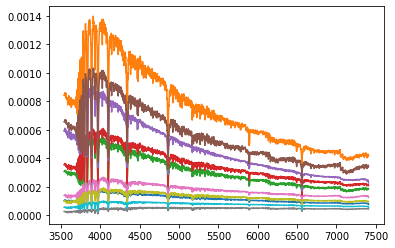

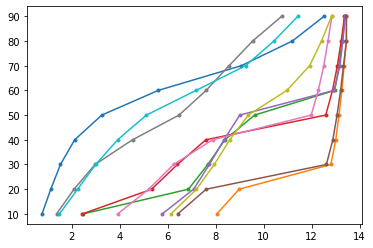

In [5]:

for i in range(10):
    plt.plot(wave, seds[i,:],c='C'+str(i))
plt.show()

for i in range(10):
    plt.plot(y[i,:9],np.arange(10,100,10),'.-',c='C'+str(i))
plt.show()


Create a Pytorch dataset for the spectra, percentiles and metallicity

In [6]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self,x,y):

        """ generate and organize artificial data from parametrizations of SFHs"""

        self.x=torch.from_numpy(x) #seds
        self.y=torch.from_numpy(y) #percentiles +  metallicity


    def __len__(self):
        """total number of samples"""
        return len(self.x[:,0])

    def __getitem__(self,index):
        """Generates one sample of data"""
        x=self.x[index,:]
        y=self.y[index,:]
        return x,y


Load encoder model and predict the latent vectors for 1.000 galaxies

In [7]:
#create a pytorch dataset

dataset = Dataset(seds[:1000,:], y[:1000,:])
params={'batch_size': 1 } 
generator = torch.utils.data.DataLoader(dataset,**params) #without minibatches

#call accelerator
accelerator = Accelerator(mixed_precision='fp16')
loader = accelerator.prepare(generator)

#load model
n_latent=16
model_file = "./saved_models/checkpoint.pt"
model, loss = load_model(model_file, device=accelerator.device,n_hidden=(16,32),n_out=10)
model = accelerator.prepare(model)
        
#predict
ss=[]
ys_=[]
print('Getting latent vectors and predicted percentiles')
with torch.no_grad():
    model.eval()
    for  batch in tqdm(loader):
                s,y_ = model._forward(batch[0].float())
                ss.append(s.cpu().numpy())
                ys_.append(y_.cpu().numpy())

ss=np.array(ss)[:,0,:]

/opt/python/python3.8/lib/python3.8/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")

  0%|                                                                                                                                                    | 0/1000 [00:00<?, ?it/s]

Getting latent vectors and predicted percentiles


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.05it/s]


Load Normalizing Flows model

In [8]:
file="./saved_models/my_posterior.pkl"

file = open(file, 'rb')
qphi = pickle.load(file)
file.close()

Predict a single evaluation of the posteriors with the Normalizing Flows

In [9]:
posteriors=[]


for i in trange(1000):
    posteriors.append(np.array(qphi.sample((1,), 
                                     x=torch.as_tensor(ss[i,:]).to('cpu'), 
                                     show_progress_bars=False).detach().to('cpu')))
posteriors=np.array(posteriors)[:,0,:]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:22<00:00, 43.58it/s]


So, time needed to generate the latent vector:
    
32/1000=0.032 s

Time to generate a single sample (not a distribution):

19/1000= 0.019 s

In total, for a single prediction of the 9 percentiles + metallicity:

0.032 + 0.019 = 0.051 s


Right now we try to predict distributions (1000 samples)

In [11]:
posteriors_dist=[]


for i in trange(1000):
    posteriors_dist.append(np.array(qphi.sample((1000,), 
                                     x=torch.as_tensor(ss[i,:]).to('cpu'), 
                                     show_progress_bars=False).detach().to('cpu')))
posteriors_dist=np.array(posteriors_dist)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:54<00:00,  8.72it/s]


Time for 1000 predictions for each galaxy:

(5*60+58) /1000 = 0.358 s

In total:

0.032+0.358= 0.39 s